In [2]:
!pip install facenet_pytorch


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import random
import os
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.nn.modules.distance import PairwiseDistance
from torch.nn.functional import cosine_similarity
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


class FaceTripletDataset(Dataset):
    def __init__(self, root_dir, train_dir, transform=None, num_triplets=1000):

        self.root_dir = root_dir
        self.train_dir = train_dir
        self.transform = transform
        self.num_triplets = num_triplets

        # Load anchors from BIZOS folder
        self.anchors = self.load_anchors()
        self.anchor_names = list(self.anchors.keys())

        # Get list of classes from train folder
        self.classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    def load_anchors(self):
        # Load anchor image from BIZOS folder
        bizos_path = self.root_dir
        anchors = {file.split(".")[0]: os.path.join(bizos_path, file) for file in os.listdir(bizos_path)}
        return anchors

    def __len__(self):
        return self.num_triplets  # Dataset Increase

    def __getitem__(self, idx):
        person = random.choice(self.anchor_names)
        anchor_path = self.anchors[person]

        # positive image
        person_folder = os.path.join(self.train_dir, person)
        positive_list = os.listdir(person_folder)
        positive_path = os.path.join(person_folder, random.choice(positive_list))

        # negative image
        negative_person = random.choice([p for p in self.classes if p != person])
        negative_folder = os.path.join(self.train_dir, negative_person)
        negative_list = os.listdir(negative_folder)
        negative_path = os.path.join(negative_folder, random.choice(negative_list))

        # Load and transform images
        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative



In [5]:
bizos_path = "/teamspace/studios/this_studio/dataset/BIZOS"
train_path = "/teamspace/studios/this_studio/dataset/train"
val_path = "/teamspace/studios/this_studio/dataset/val"
# test_path = "/content/drive/MyDrive/final_project_bajra/dataset/test"

train_dataset = FaceTripletDataset(root_dir=bizos_path,train_dir=train_path, transform=transform,num_triplets=10000)
val_dataset = FaceTripletDataset(root_dir=bizos_path,train_dir=val_path, transform=transform,num_triplets=1250)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False,drop_last=True)

In [6]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.facenet=InceptionResnetV1(pretrained='casia-webface',classify=False).train()
    self.facenet.last_bn=torch.nn.Identity()
    self.facenet.logits=torch.nn.Identity()
    self.freeze()


  def freeze(self):
    for param in self.facenet.parameters():
      param.requires_grad_(True)

    # for param in self.facenet.block8.parameters():
    #   param.requires_grad_(True)

    # for param in self.facenet.last_linear.parameters():
    #   param.requires_grad_(True)

  def forward(self,x):

    return self.facenet(x)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model().to(device)

# Define Triplet Loss
criterion = torch.nn.TripletMarginLoss(margin=1)
optimizer = optim.Adam(model.parameters(), lr=2e-5,weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [11]:
def semi_hard_negative_mining(anchor_emb, positive_emb, negative_emb):
    pos_dist = F.pairwise_distance(anchor_emb, positive_emb, p=2)
    neg_dist = F.pairwise_distance(anchor_emb, negative_emb, p=2)

    # Select semi-hard negatives
    mask = (neg_dist > pos_dist) & (neg_dist < pos_dist + 1)  # Semi-hard condition
    return mask

In [12]:
num_epochs = 50
patience = 7
best_val_loss = float('inf')
counter = 0
writer = SummaryWriter()
train_loss = []
val_loss = []

for epoch in range(num_epochs):
  model.train()
  batch_train_loss = []

  for anchor, positive, negative in tqdm(train_loader,leave=False):
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

    anchor_emb = model(anchor)
    positive_emb = model(positive)
    negative_emb = model(negative)

    mask = semi_hard_negative_mining(anchor_emb, positive_emb, negative_emb)

    if mask.sum() > 0:
      trainloss = criterion(anchor_emb[mask], positive_emb[mask], negative_emb[mask])
      batch_train_loss.append(trainloss.item())

      optimizer.zero_grad()
      trainloss.backward()
      optimizer.step()

  model.eval()
  batch_val_loss = []
  with torch.no_grad():
    for anchor, positive, negative in tqdm(val_loader,leave=False):
      anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
      anchor_emb = model(anchor)
      positive_emb = model(positive)
      negative_emb = model(negative)

      valloss = criterion(anchor_emb, positive_emb, negative_emb)
      batch_val_loss.append(valloss.item())

  epoch_train_loss = sum(batch_train_loss) / len(batch_train_loss)
  epoch_val_loss = sum(batch_val_loss) / len(batch_val_loss)
  writer.add_scalar("Loss/Train", epoch_train_loss, epoch)
  writer.add_scalar("Loss/Validation", epoch_val_loss, epoch)


  train_loss.append(epoch_train_loss)
  val_loss.append(epoch_val_loss)
  scheduler.step(epoch_val_loss)
  print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

  if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    counter = 0
    torch.save(model.state_dict(), "/teamspace/studios/this_studio/model/best_model.pth")
    print("Model saved!")
  else:
    counter += 1
    if counter >= patience:
      print(f"Early stopping triggered after {epoch+1} epochs.")
      break

print("Training Complete!")


Epoch: 0 | Train Loss: 0.6634 | Val Loss: 0.7420
Model saved!


Epoch: 1 | Train Loss: 0.4320 | Val Loss: 0.5275
Model saved!


Epoch: 2 | Train Loss: 0.4190 | Val Loss: 0.3998
Model saved!


Epoch: 3 | Train Loss: 0.3816 | Val Loss: 0.3633
Model saved!


Epoch: 4 | Train Loss: 0.3128 | Val Loss: 0.3341
Model saved!


Epoch: 5 | Train Loss: 0.2492 | Val Loss: 0.2897
Model saved!


Epoch: 6 | Train Loss: 0.1774 | Val Loss: 0.2602
Model saved!


Epoch: 7 | Train Loss: 0.1227 | Val Loss: 0.2944


Epoch: 8 | Train Loss: 0.0775 | Val Loss: 0.2566
Model saved!


Epoch: 9 | Train Loss: 0.0893 | Val Loss: 0.2754


Epoch: 10 | Train Loss: 0.1027 | Val Loss: 0.2767


Epoch: 11 | Train Loss: 0.0949 | Val Loss: 0.1640
Model saved!


Epoch: 12 | Train Loss: 0.1112 | Val Loss: 0.2189


Epoch: 13 | Train Loss: 0.0818 | Val Loss: 0.2161


Epoch: 14 | Train Loss: 0.1077 | Val Loss: 0.1853


Epoch: 15 | Train Loss: 0.0540 | Val Loss: 0.2038


Epoch: 16 | Train Loss: 0.0593 | Val Loss: 0.1822


Epoch: 17 | Train Loss: 0.0476 | Val Loss: 0.1595
Model saved!


Epoch: 18 | Train Loss: 0.0736 | Val Loss: 0.1455
Model saved!


Epoch: 19 | Train Loss: 0.0488 | Val Loss: 0.1485


Epoch: 20 | Train Loss: 0.0541 | Val Loss: 0.1942


Epoch: 21 | Train Loss: 0.0363 | Val Loss: 0.2011


Epoch: 22 | Train Loss: 0.0367 | Val Loss: 0.1676


Epoch: 23 | Train Loss: 0.0364 | Val Loss: 0.1808


Epoch: 24 | Train Loss: 0.0601 | Val Loss: 0.1778


Epoch: 25 | Train Loss: 0.0190 | Val Loss: 0.1640
Early stopping triggered after 26 epochs.
Training Complete!


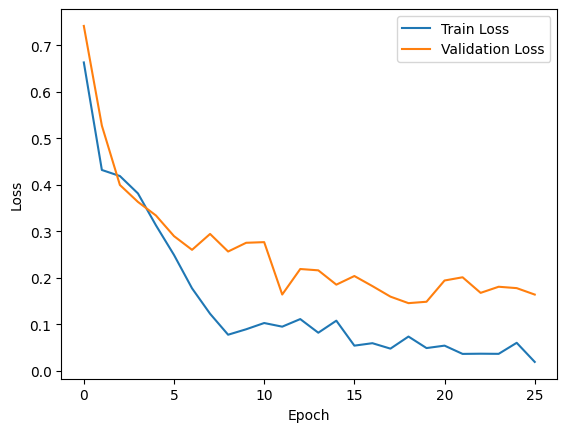

In [13]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()